# Their Dataset

## Testing

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
import os, argparse
from lib.TransFuse import TransFuse_S, TransFuse_L, TransFuse_L_384
from utils.dataloader import test_dataset
import imageio



def mean_iou_np(y_true, y_pred, **kwargs):
    """
    compute mean iou for binary segmentation map via numpy
    """
    axes = (0, 1) 
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) 
    mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask_sum  - intersection 
    
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    return iou


def mean_dice_np(y_true, y_pred, **kwargs):
    """
    compute mean dice for binary segmentation map via numpy
    """
    axes = (0, 1) # W,H axes of each image
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) 
    mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    
    smooth = .001
    dice = 2*(intersection + smooth)/(mask_sum + smooth)
    return dice


In [17]:
# Argument Inputs

ckpt_path = 'snapshots/TransFuse-19_best.pth'   # Path to the checkpoint
test_path = 'data/'     # Path to test dataset
save_path = 'save/'        # Path to save inference segmentation

In [18]:
if __name__ == '__main__':
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = TransFuse_S().to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

    print('Evaluating model:', ckpt_path)

    image_root = f'{test_path}/data_test.npy'
    gt_root = f'{test_path}/mask_test.npy'
    test_loader = test_dataset(image_root, gt_root)

    # Prepare storage for predictions
    all_images = []
    all_gts = []
    all_predictions = []

    dice_bank = []
    iou_bank = []
    acc_bank = []

    for i in range(test_loader.size):
        # Load data
        image, gt = test_loader.load_data()
        gt = (gt > 0.5).astype(np.uint8)  # Binary mask

        # Move image to the device
        image = image.to(device)

        with torch.no_grad():
            _, _, res = model(image)

        res = res.sigmoid().data.cpu().numpy().squeeze()  # Shape: (height, width)
        res = (res > 0.5).astype(np.uint8)  # Threshold to binary

        # Save predictions for later visualization
        all_images.append(image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Convert tensor to NumPy
        all_gts.append(gt)
        all_predictions.append(res)

        # Save predictions if save_path is set
        if save_path is not None:
            pred_npy_path = f'{save_path}/predicted_test.npy'
            np.save(pred_npy_path, np.array(all_predictions))

        # Compute metrics
        dice = mean_dice_np(gt, res)
        iou = mean_iou_np(gt, res)
        acc = np.sum(res == gt) / (res.shape[0] * res.shape[1])

        acc_bank.append(acc)
        dice_bank.append(dice)
        iou_bank.append(iou)

    print('Dice: {:.4f}, IoU: {:.4f}, Acc: {:.4f}'.
          format(np.mean(dice_bank), np.mean(iou_bank), np.mean(acc_bank)))


Using device: cpu


/var/folders/dy/crwmhrjj0cqbyz9960bfh8zm0000gn/T/ipykernel_4607/1245050436.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, ma

Evaluating model: snapshots/TransFuse-19_best.pth
Dice: 0.8754, IoU: 0.8008, Acc: 0.9468


## Visualization

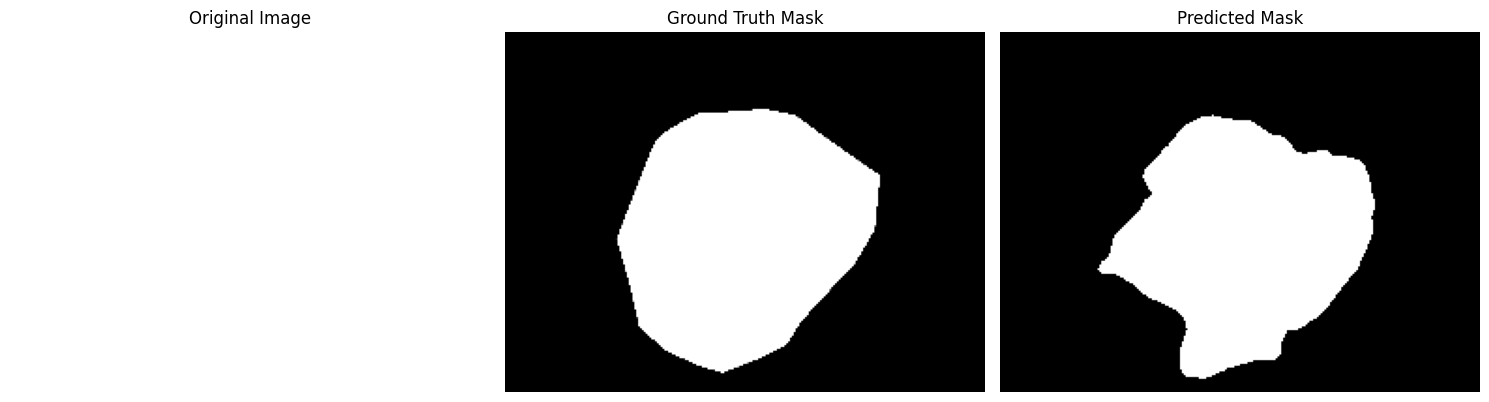

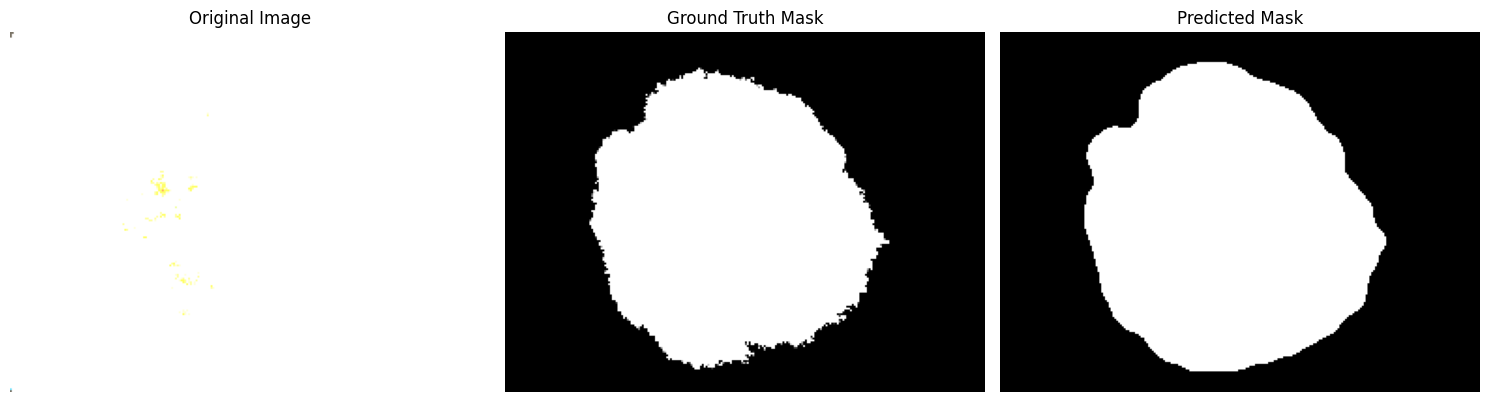

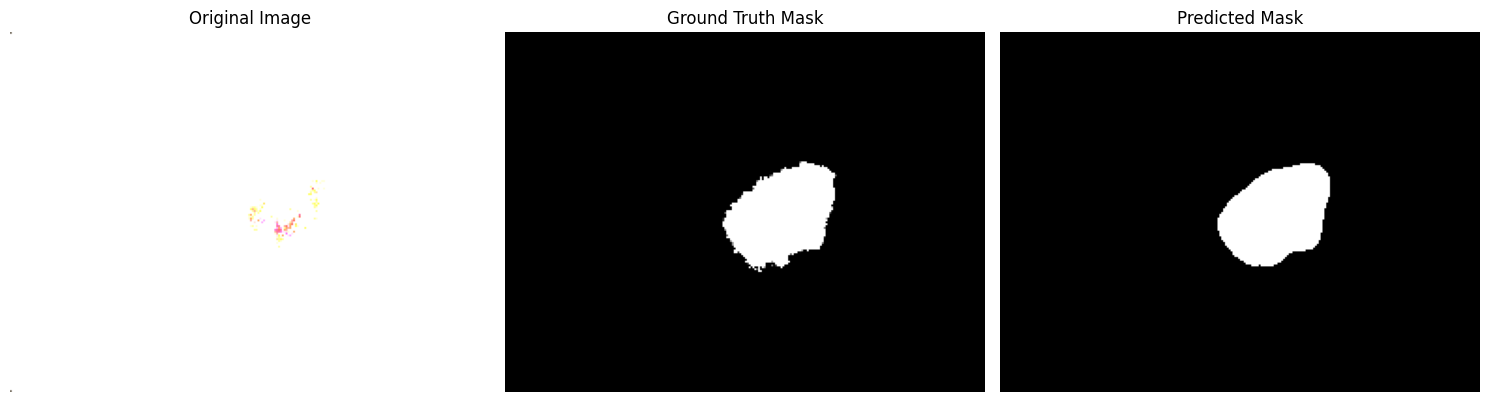

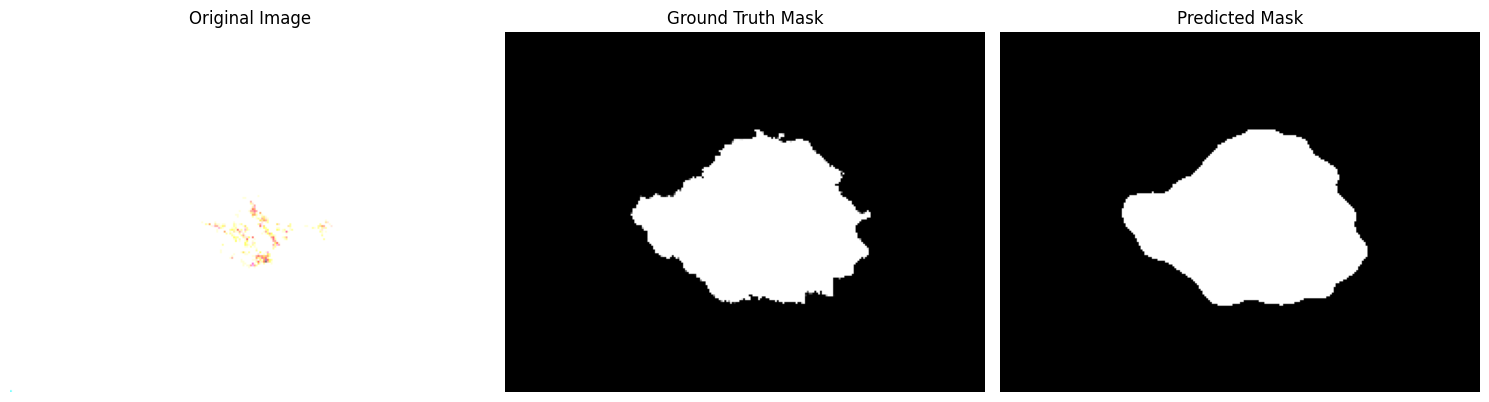

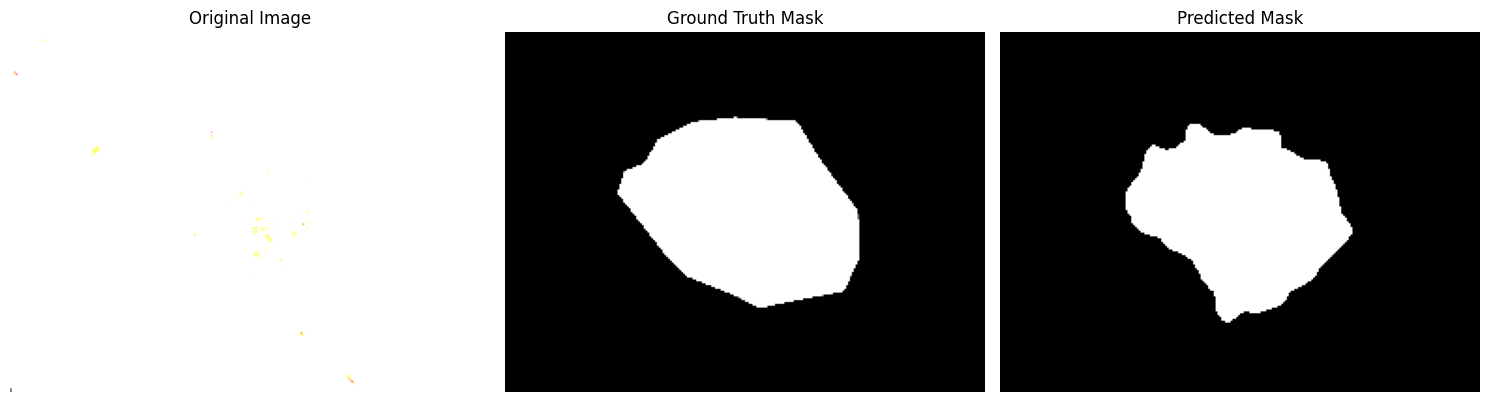

In [19]:
import random
import matplotlib.pyplot as plt


def visualize_samples_from_npy(image_path, gt_path, pred_path, sample_count=5):
    """
    Visualize random samples of images, ground truth masks, and predictions from .npy files.
    
    Args:
        image_path (str): Path to the .npy file containing images.
        gt_path (str): Path to the .npy file containing ground truth masks.
        pred_path (str): Path to the .npy file containing predicted masks.
        sample_count (int): Number of samples to visualize.
    """
    # Load the data from .npy files
    images = np.load(image_path)
    gts = np.load(gt_path)
    predictions = np.load(pred_path)

    # Randomly sample indices
    indices = random.sample(range(len(images)), sample_count)
    for idx in indices:
        # Retrieve image, ground truth, and prediction
        image = images[idx]
        gt = gts[idx]
        pred = predictions[idx]

        # Convert image from normalized to displayable range
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        image = np.clip(image, 0, 1)  # Clip to valid range

        # Display the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[1].imshow(gt, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[2].imshow(pred, cmap='gray')
        axes[2].set_title('Predicted Mask')
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Paths to .npy files
image_npy = f'{test_path}/data_test.npy'
gt_npy = f'{test_path}/mask_test.npy'
pred_npy = f'{save_path}/predicted_test.npy'

visualize_samples_from_npy(image_npy, gt_npy, pred_npy, sample_count=5)


## Training

In [20]:
import torch
from torch.autograd import Variable
import argparse
from datetime import datetime
from lib.TransFuse import TransFuse_S, TransFuse_L, TransFuse_L_384
from utils.dataloader import get_loader, test_dataset
from utils.utils import AvgMeter
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from test_isic import mean_dice_np, mean_iou_np
import os


def structure_loss(pred, mask):
    weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduction='none')
    wbce = (weit*wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask)*weit).sum(dim=(2, 3))
    union = ((pred + mask)*weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1)/(union - inter+1)
    return (wbce + wiou).mean()


def train(train_loader, model, optimizer, epoch, best_loss):
    model.train()
    loss_record2, loss_record3, loss_record4 = AvgMeter(), AvgMeter(), AvgMeter()
    accum = 0
    for i, pack in enumerate(train_loader, start=1):
        # ---- data prepare ----
        images, gts = pack
        images = Variable(images).cuda()
        gts = Variable(gts).cuda()

        # ---- forward ----
        lateral_map_4, lateral_map_3, lateral_map_2 = model(images)

        # ---- loss function ----
        loss4 = structure_loss(lateral_map_4, gts)
        loss3 = structure_loss(lateral_map_3, gts)
        loss2 = structure_loss(lateral_map_2, gts)

        loss = 0.5 * loss2 + 0.3 * loss3 + 0.2 * loss4

        # ---- backward ----
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), opt.grad_norm)
        optimizer.step()
        optimizer.zero_grad()

        # ---- recording loss ----
        loss_record2.update(loss2.data, opt.batchsize)
        loss_record3.update(loss3.data, opt.batchsize)
        loss_record4.update(loss4.data, opt.batchsize)

        # ---- train visualization ----
        if i % 20 == 0 or i == total_step:
            print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                  '[lateral-2: {:.4f}, lateral-3: {:0.4f}, lateral-4: {:0.4f}]'.  
                  format(datetime.now(), epoch, opt.epoch, i, total_step,
                         loss_record2.show(), loss_record3.show(), loss_record4.show()))

    save_path = 'snapshots/{}/'.format(opt.train_save)
    os.makedirs(save_path, exist_ok=True)
    if (epoch+1) % 1 == 0:
        meanloss = test(model, opt.test_path)
        if meanloss < best_loss:
            print('new best loss: ', meanloss)
            best_loss = meanloss
            torch.save(model.state_dict(), save_path + 'TransFuse-%d.pth' % epoch)
            print('[Saving Snapshot:]', save_path + 'TransFuse-%d.pth'% epoch)
    return best_loss


def test(model, path):

    model.eval()
    mean_loss = []

    for s in ['val', 'test']:
        image_root = '{}/data_{}.npy'.format(path, s)
        gt_root = '{}/mask_{}.npy'.format(path, s)
        test_loader = test_dataset(image_root, gt_root)

        dice_bank = []
        iou_bank = []
        loss_bank = []
        acc_bank = []

        for i in range(test_loader.size):
            image, gt = test_loader.load_data()
            image = image.cuda()

            with torch.no_grad():
                _, _, res = model(image)
            loss = structure_loss(res, torch.tensor(gt).unsqueeze(0).unsqueeze(0).cuda())

            res = res.sigmoid().data.cpu().numpy().squeeze()
            gt = 1*(gt>0.5)            
            res = 1*(res > 0.5)

            dice = mean_dice_np(gt, res)
            iou = mean_iou_np(gt, res)
            acc = np.sum(res == gt) / (res.shape[0]*res.shape[1])

            loss_bank.append(loss.item())
            dice_bank.append(dice)
            iou_bank.append(iou)
            acc_bank.append(acc)
            
        print('{} Loss: {:.4f}, Dice: {:.4f}, IoU: {:.4f}, Acc: {:.4f}'.
            format(s, np.mean(loss_bank), np.mean(dice_bank), np.mean(iou_bank), np.mean(acc_bank)))

        mean_loss.append(np.mean(loss_bank))

    return mean_loss[0] 

In [21]:
# Inputs
epoch = 25                  # epoch number
lr = 7e-5               # learning rate
batchsize = 16          # batch size
grad_norm = 2.0         # gradient clipping norm
train_path = 'data/'        # Path to training dataset
test_path = 'data/'         # Path to testing dataset
train_save = 'TransFuse_S'  # Name of training snapshot
beta1 = 0.5             # Adam optimizer beta1
beta2 = 0.999           # Adam optimizer beta2



In [22]:
if __name__ == '__main__':
    # ---- build models ----
    model = TransFuse_S(pretrained=True).cuda()
    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr, betas=(beta1, beta2))
     
    image_root = '{}/data_train.npy'.format(train_path)
    gt_root = '{}/mask_train.npy'.format(train_path)

    train_loader = get_loader(image_root, gt_root, batchsize=batchsize)
    total_step = len(train_loader)

    print("#"*20, "Start Training", "#"*20)

    best_loss = 1e5
    for epoch in range(1, epoch + 1):
        best_loss = train(train_loader, model, optimizer, epoch, best_loss)


/Users/killercookie/DeepM/TransFuse-baseline/lib/TransFuse.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.resnet.load_state_dict(torch.load('pretrained/resnet34-3

FileNotFoundError: [Errno 2] No such file or directory: 'pretrained/resnet34-333f7ec4.pth'

# Process Our Data

## Test Our Data

## Train Our Data

# Evaluation